1. Hãy train model resnet152 với việc train luôn cả backbone resnet152
2. Hãy viết thêm một def predict_step trong class Model để phục vụ cho mục đích dự đoán các giá trị đầu vào.
3. Dùng test_loader chứa các ảnh ở tập test làm đầu vào cho model để dự đoán các labels cho tập này


In [ ]:
pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 23.7 MB/s eta 0:00:00


In [ ]:
#download dataset
!gdown 197JiJUIXbXpZylimFqtBz9DeA_dn2BLa
!unzip /content/data_17K.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/pure/dc354_silkcut_002_bottom_212.png  
  inflating: data/train/pure/dc354_discolored_000_bottom_062.png  
  inflating: data/train/pure/dc354_broken_004_bottom_228.png  
  inflating: data/train/pure/new_dc317_discolored_002_top_284.png  
  inflating: data/train/pure/new_dc317_discolored_002_bottom_036.png  
  inflating: data/train/pure/dc354_discolored_000_bottom_276.png  
  inflating: data/train/pure/new_dc354_broken_001_top_220.png  
  inflating: data/train/pure/new_dc317_silkcut_001_top_180.png  
  inflating: data/train/pure/new_dc317_discolored_001_bottom_142.png  
  inflating: data/train/pure/new_dc317_silkcut_000_top_216.png  
  inflating: data/train/pure/dc354_discolored_004_bottom_091.png  
  inflating: data/train/pure/new_dc354_broken_001_top_255.png  
  inflating: data/train/pure/dc354_discolored_006_top_137.png  
  inflating: data/train/pure/dc354_discolored_003_bottom_059.png  
  inflating: data/trai

#Demo

In [ ]:
#import thư viện
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torch
import torchvision
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F

In [ ]:
val_path = "/content/data/validation/"
train_path = "/content/data/train/"
list_ = [name for name in os.listdir(train_path)]

In [ ]:
NAME2NUMBER = {}
for index, label in enumerate(list_):
  NAME2NUMBER[label] = index

def get_path(path):
  paths = []
  for name in list_:
    l = glob.glob(f"{path}{name}/*.png")
    for i in l:
      paths.append({"name": name,
                    "path": i,
                    "label": NAME2NUMBER[name]})
  return paths


train_paths = get_path(train_path)
val_paths = get_path(val_path)


In [ ]:
class DataSet(torch.utils.data.Dataset):

  def __init__(self, features, new_size = (224, 224)):
    super(DataSet, self).__init__()
    self.features = features
    self.resize_transform = torchvision.transforms.Resize(new_size)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    paths = self.features[idx]["path"]
    image = torchvision.io.read_image(paths) / 255.0
    image = self.resize_transform(image)
    label = torch.tensor(self.features[idx]["label"])
    return {"image": image,
            "label": label}

Data = DataSet(val_paths)
next(iter(Data))['image'].shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224])

In [ ]:
def show(imgs, num_images):
    if not isinstance(imgs, list):
        imgs = [imgs]
    imgs = imgs[:num_images]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

In [ ]:
class DataModule(L.LightningDataModule):
  def __init__(self, batch_size, num_workers, train_path, val_path):
    super(DataModule, self).__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.batch_size = batch_size
    self.num_workers = num_workers

  def setup(self, stage=None):
    train_paths = get_path(self.train_path)
    val_paths = get_path(self.val_path)
    train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

    self.train_dataset = DataSet(train_paths)
    self.val_dataset = DataSet(val_paths)
    self.test_dataset = DataSet(test_paths)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)


data_module = DataModule(32, 2, train_path, val_path)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

next(iter(test_loader))

{'image': tensor([[[[0.8078, 0.8078, 0.8078,  ..., 0.7848, 0.7964, 0.8039],
           [0.8063, 0.8069, 0.8078,  ..., 0.7863, 0.7960, 0.8024],
           [0.8040, 0.8055, 0.8077,  ..., 0.7885, 0.7955, 0.8001],
           ...,
           [0.8195, 0.8166, 0.8121,  ..., 0.8309, 0.8264, 0.8235],
           [0.8172, 0.8160, 0.8143,  ..., 0.8241, 0.8238, 0.8235],
           [0.8157, 0.8157, 0.8157,  ..., 0.8197, 0.8220, 0.8235]],
 
          [[0.8431, 0.8446, 0.8470,  ..., 0.8393, 0.8416, 0.8431],
           [0.8461, 0.8465, 0.8470,  ..., 0.8393, 0.8407, 0.8416],
           [0.8508, 0.8493, 0.8472,  ..., 0.8392, 0.8393, 0.8393],
           ...,
           [0.8626, 0.8641, 0.8665,  ..., 0.8624, 0.8602, 0.8588],
           [0.8603, 0.8618, 0.8641,  ..., 0.8579, 0.8585, 0.8588],
           [0.8588, 0.8603, 0.8626,  ..., 0.8550, 0.8573, 0.8588]],
 
          [[0.8235, 0.8235, 0.8235,  ..., 0.8196, 0.8196, 0.8196],
           [0.8250, 0.8227, 0.8192,  ..., 0.8182, 0.8200, 0.8211],
           [0.8

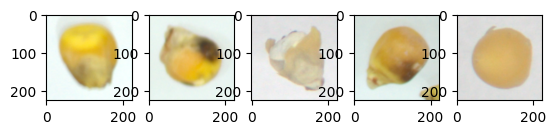

In [ ]:
images = [image for image in next(iter(train_loader))["image"]]
show(images, 5)

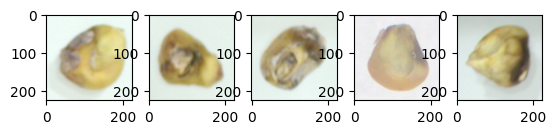

In [ ]:
images = [image for image in next(iter(val_loader))["image"]]
show(images, 5)

In [ ]:
class Model(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=4):
    super(Model, self).__init__()
    backbone = torchvision.models.resnet152(weights="DEFAULT")
    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]

    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.is_train = is_train
    self.learning_rate = learning_rate
    self.loss = torch.nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_target_classes)

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)
    acc = self.accuracy(y_pred, y)
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)
    val_acc = self.accuracy(y_pred, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["image"]
    y = batch["label"]
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)
    test_acc = self.accuracy(y_pred, y)
    self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
    x, _ = batch['image'], batch['label']
    y_pred = self(x)
    prob = torch.softmax(y_pred, dim=1)
    predicted_labels = torch.argmax(prob, dim=1)
    return {"y_pred": predicted_labels}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)  #
    return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="min",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="min", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

model = Model()
data_module = DataModule(512, 1, train_path, val_path)
trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 139MB/s]
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available:

In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 58.1 M
1 | classifier        | Linear             | 8.2 K 
2 | loss              | CrossEntropyLoss   | 0     
3 | accuracy          | MulticlassAccuracy | 0     
---------------------------------------------------------
58.2 M    Trainable params
0         Non-trainable params
58.2 M    Total params
232.608   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 58.1 M
1 | classifier        | Linear             | 8.2 K 
2 | loss              | CrossEntropyLoss   | 0     
3 | accuracy          | MulticlassAccuracy

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  w

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 23: 'val_acc' reached 0.56597 (best 0.56597), saving model to '/content/checkpoint/epoch=0-step=23.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 23: 'val_acc' reached 0.56597 (best 0.56597), saving model to '/content/checkpoint/epoch=0-step=23.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 46: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 46: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 69: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 69: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 92: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 92: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias p

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 115: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 115: 'val_acc' was not in top 1
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 138: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 138: 'val_acc' was not in top 1


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6691099405288696     │
│         test_loss         │    0.8154426217079163     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8154426217079163, 'test_acc': 0.6691099405288696}]

In [ ]:
#prediction
#test_loader có dạng torch.utils.data.DataLoader
data_module = DataModule(64, 2, train_path, val_path)
data_module.setup()
test_loader = data_module.test_dataloader()
prediction = trainer.predict(model, dataloaders = test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the re

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
model = Model.load_from_checkpoint('/content/checkpoint/epoch=0-step=23.ckpt')
predictions = trainer.predict(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the re

Predicting: |          | 0/? [00:00<?, ?it/s]